Goal: perform SCA from the ground up on our collection of nar sequences. First, an MSA was performed with the online tool Clustal Omega. The results were stored in `out/aaseqs/K00370/MSA_complete_seqs.aln-fasta`.

First, load in the MSA, make a numerical matrix. 

In [1]:
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt

# Load MSA
msa = AlignIO.read("../out/aaseqs/K00370/MSA_800.aln-fasta", "fasta")

# Convert letters to numbers (0-20 for AAs + gap)
aa_to_int = {aa: i for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY-")}
msa_matrix = np.array([
    [aa_to_int[aa] for aa in record.seq] 
    for record in msa
])

print(f"MSA shape: {msa_matrix.shape} (sequences x positions)")

num_positions = msa_matrix.shape[1]
num_aas = 21  # 20 amino acids + gap


MSA shape: (118, 1417) (sequences x positions)


let's remove columns in the matrix with less than 50% coverage. The motivation for this is to handle length inflation from the MSA. 

Filtered MSA: 717 positions (was 1188)


Text(0.5, 1.0, 'narG collection (pixel color = amino acid)')

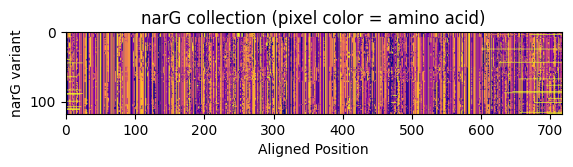

In [3]:
#let's remove columns in the matrix with less than 50% coverage. The motivation for this is to handle length inflation from the MSA. 
num_positions = len(msa_matrix[0])

num_seqs, num_positions = msa_matrix.shape

gap_threshold = 0.1 * num_seqs
clean_columns = [
    col for col in range(num_positions) 
    if np.sum(msa_matrix[:, col] == aa_to_int['-']) <= gap_threshold
]
msa_matrix = msa_matrix[:, clean_columns]
print(f"Filtered MSA: {msa_matrix.shape[1]} positions (was {num_positions})")
plt.show()
plt.imshow(msa_matrix, cmap = 'plasma')
plt.ylabel('narG variant')
plt.xlabel('Aligned Position')
plt.title('narG collection (pixel color = amino acid)')




functions defined below

In [7]:
num_seqs, num_positions = msa_matrix.shape

def raw_covariance(MSA):
    aa_to_int = {aa: i for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY-")}
    msa_matrix = MSA.copy()  
    
    

    num_aas = 20  # 20 b/ we're excluding gaps
    f_i = np.zeros((num_positions, num_aas))
    pseudocount = 1.0  # A pseudo count for stability
    
    for pos in range(num_positions):
        column = msa_matrix[:, pos]
        mask = (column != aa_to_int['-'])  
        valid_aas = column[mask]
        
        # count aa frequencies
        counts = np.bincount(valid_aas, minlength=num_aas) + pseudocount
        f_i[pos] = counts / (counts.sum() + num_aas*pseudocount)  # normalize
    
    # joint frequencies
    f_ij = np.zeros((num_positions, num_positions, num_aas, num_aas))
    
    for i in range(num_positions):
        for j in range(i, num_positions):  # only upper triangle
            pairs = msa_matrix[:, [i, j]]
            mask = (pairs[:, 0] != aa_to_int['-']) & (pairs[:, 1] != aa_to_int['-'])
            valid_pairs = pairs[mask]
            
            if len(valid_pairs) > 0:
                # Use einsum with pseudocount
                joint_counts = np.einsum('si,sj->ij', 
                                       np.eye(num_aas)[valid_pairs[:, 0]],
                                       np.eye(num_aas)[valid_pairs[:, 1]]) + pseudocount/num_aas
                f_ij[i, j] = joint_counts / (len(valid_pairs) + pseudocount)
                
                # Symmetrize
                if i != j:
                    f_ij[j, i] = f_ij[i, j].T
    
    # Compute stabilized covariance
    obs = f_ij
    exp = f_i[:, None, :, None] * f_i[None, :, None, :]
    
    # Clip differences to avoid extreme values
    diff = np.clip(obs - exp, -1, 1)  # Clip to [-1, 1] range
    cov_matrix = np.sqrt(np.sum(diff**2, axis=(-2, -1)))  # L2 norm
    
    return f_i, f_ij, cov_matrix

In [8]:
f_i, f_ij, cov_raw = raw_covariance(msa_matrix)

In [10]:
# Example background frequencies (Jones et al., 1992)
background = {
    'A': 0.078, 'C': 0.020, 'D': 0.053, 'E': 0.063,
    'F': 0.039, 'G': 0.072, 'H': 0.023, 'I': 0.053,
    'K': 0.059, 'L': 0.091, 'M': 0.022, 'N': 0.043,
    'P': 0.052, 'Q': 0.042, 'R': 0.051, 'S': 0.071,
    'T': 0.058, 'V': 0.066, 'W': 0.014, 'Y': 0.033
}

aa_order = "ACDEFGHIKLMNPQRSTVWY"
p_a = np.array([background[aa] for aa in aa_order])

In [29]:


def compute_cov_corrected(f_i, f_ij, p_a):
    """
    Memory-efficient computation of corrected covariance matrix.
    
    Args:
        f_i:    (L, A) array of position-specific amino acid frequencies
        f_ij:   (L, L, A, A) array of pairwise amino acid frequencies
        p_a:    (A,) array of background amino acid frequencies
    
    Returns:
        cov_corrected: (L, L) array of corrected covariation scores
    """
    L, A = f_i.shape
    cov_corrected = np.zeros((L, L))

    # pre compute correction terms, eps included to avoid nans/infs
    eps = 1e-10
    numerator = (f_i + eps) * (1 - p_a)
    denominator = (1 - f_i - eps) * p_a
    log_odds = np.log(numerator / denominator)
    log_odds = np.nan_to_num(log_odds, nan=0.0, posinf=0.0, neginf=0.0)

    for i in range(L):
        for j in range(L):
            cov_term = f_ij[i, j] - np.outer(f_i[i], f_i[j])
            correction = log_odds[i][:, None] * log_odds[j][None, :] * cov_term
            cov_corrected[i, j] = np.sum(correction**2)
    
    
    diag = np.diag(cov_corrected)
    cov_corrected /= np.sqrt(np.outer(diag, diag))


    return cov_corrected



In [30]:
cov = compute_cov_corrected(f_i, f_ij, p_a)

plot covariance matrix

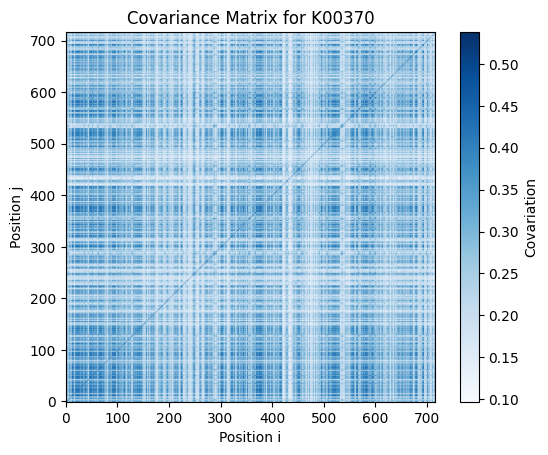

Text(0.5, 1.0, 'Corrected Covariance Matrix for K00370')

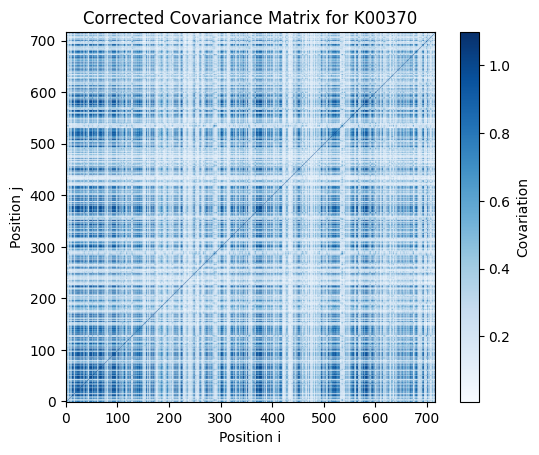

In [31]:

plt.imshow(cov_raw, cmap = 'Blues', origin = 'lower')
plt.colorbar(label="Covariation")
plt.xlabel("Position i"); plt.ylabel("Position j")
plt.title('Covariance Matrix for K00370')
plt.show()

plt.imshow(cov, cmap = 'Blues', origin = 'lower')
plt.colorbar(label="Covariation")
plt.xlabel("Position i"); plt.ylabel("Position j")
plt.title('Corrected Covariance Matrix for K00370')

Move computation to a function

Look at modes

Text(0, 0.5, 'Singular value')

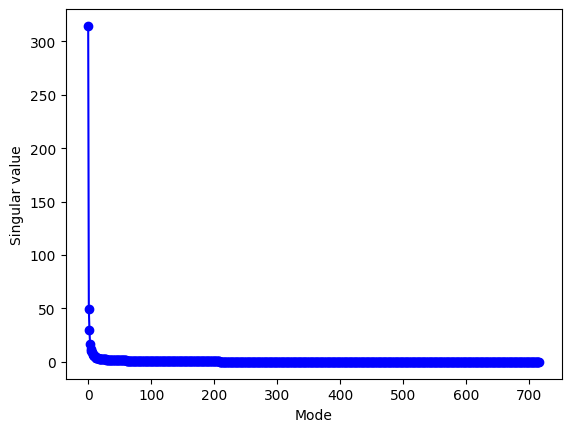

In [33]:
U, s, Vh = np.linalg.svd(cov)
plt.plot(s, 'o-', color = 'Blue')
plt.xlabel("Mode")
plt.ylabel("Singular value")

Compute first order statistics and a threshold.

[0.078 0.02  0.053 0.063 0.039 0.072 0.023 0.053 0.059 0.091 0.022 0.043
 0.052 0.042 0.051 0.071 0.058 0.066 0.014 0.033]
(118, 717)
Conservation (KL divergence): [1.90516387 1.96988822 1.67911151 1.66162023 1.36238564 2.15105682
 2.43530579 1.73150952 2.00472991 0.99656535 2.22885769 2.35712723
 2.5156238  2.64013391 2.67566633 1.68382668 1.11148803 2.34560658
 2.76414027 1.9818099  2.75664822 2.70043809 2.8895965  2.49100368
 3.81671283 2.6450754  3.81671283 1.59409221 2.6450754  3.15202021
 2.25167809 2.55104645 2.63108916 1.76056669 2.97592965 2.64601359
 2.20191311 2.6450754  2.33504497 1.94548754 2.63108916 2.15858742
 1.58180884 1.48143128 1.95014099 2.6450754  3.24419363 3.35588664
 2.93746337 4.26869795 3.41124772 2.43748382 2.93746337 2.2403251
 2.95651156 2.387196   1.9921105  2.6450754  2.95651156 2.97013607
 1.51257396 3.26686752 2.63108916 2.15950319 3.11833733 2.84731227
 2.93746337 2.71810054 2.74592414 2.71630837 2.52422929 1.61335388
 2.93746337 4.26869795 2.60740203

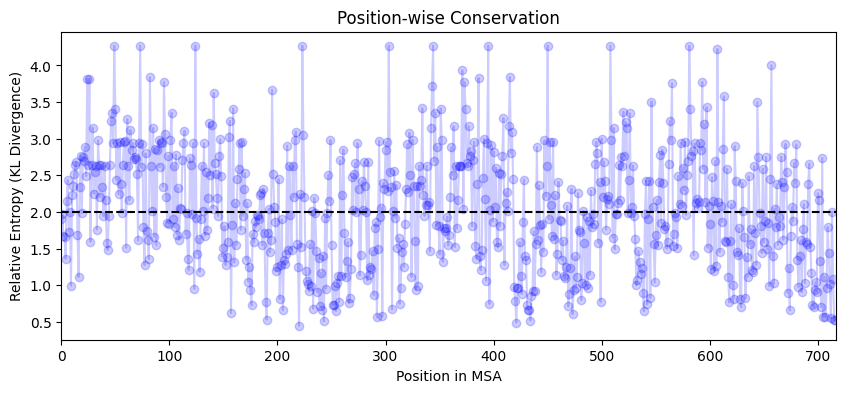

[0, 1, 2, 3, 4, 7, 9, 15, 16, 19, 27, 33, 39, 42, 43, 44, 56, 60, 71, 76, 77, 79, 80, 81, 86, 88, 98, 100, 103, 105, 107, 109, 115, 116, 117, 118, 121, 123, 125, 126, 127, 128, 129, 133, 135, 145, 149, 150, 151, 152, 153, 154, 157, 158, 160, 162, 166, 168, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 186, 188, 189, 190, 191, 193, 194, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 212, 213, 218, 219, 220, 222, 226, 227, 228, 229, 230, 231, 233, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 250, 251, 252, 253, 254, 255, 256, 257, 259, 262, 263, 264, 265, 266, 267, 268, 273, 276, 277, 282, 283, 285, 286, 287, 288, 289, 290, 291, 292, 293, 295, 297, 306, 309, 311, 312, 313, 314, 315, 316, 317, 318, 324, 327, 328, 330, 336, 341, 347, 349, 350, 353, 354, 355, 356, 357, 358, 359, 364, 366, 380, 383, 384, 387, 388, 389, 393, 396, 399, 403, 404, 406, 410, 419, 420, 421, 422, 423, 424, 425, 426, 427, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 441

In [35]:


print(p_a)
print(msa_matrix.shape)
num_seqs, num_positions = msa_matrix.shape

def compute_conservation(msa_matrix, p_a):
    '''KL divergence from each position of our sequence to the global distribution'''
    num_positions = msa_matrix.shape[1]
    num_aas = len(p_a)
    conservation = np.zeros(num_positions)
    
    for i in range(num_positions):
        # Count AA frequencies at position i (+ pseudocount)
        counts = np.bincount(msa_matrix[:, i], minlength=num_aas)
        f_i = counts / counts.sum()
        
        # Compute KL divergence: D_KL(f_i || p_a)
        kl_div = 0 
        for j in range(20): #over each amino acid
            if f_i[j] > 0:
                kl_div += f_i[j] * np.log(f_i[j] / p_a[j])
        
        conservation[i] = kl_div
    
    return conservation

thres = 2

conservation = compute_conservation(msa_matrix, p_a)
print("Conservation (KL divergence):", conservation)

# Plot conservation
plt.figure(figsize=(10, 4))
plt.plot(conservation, '-o', color = 'Blue', alpha = 0.2)
plt.xlim(0, num_positions)
plt.xlabel("Position in MSA")
plt.ylabel("Relative Entropy (KL Divergence)")
plt.title("Position-wise Conservation")
plt.axhline(thres, linestyle = '--', color = 'black', alpha = 1)
plt.show()

remove = []
for i in range(len(conservation)):
    if conservation[i] < thres:
        remove.append(i)
print(remove)

delete poorly consersved regions

In [37]:

cov_filt = np.delete(cov, remove, axis=0) 
cov_filt = np.delete(cov_filt, remove, axis=1)

print(cov_filt.shape)

(356, 356)


Shuffle for signifance check

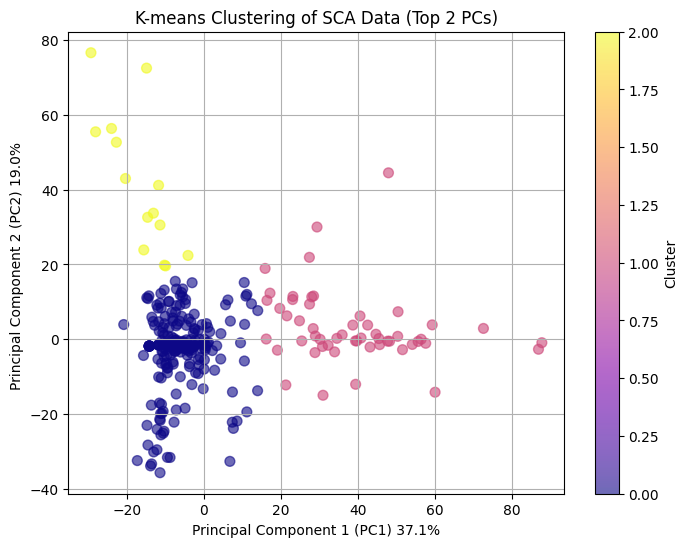

Variance explained by each PC (%): [37.11495832 18.97840944  9.89700653]


In [34]:
#do some mean centering and clustering

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

row_means = np.mean(cov_filt, axis=1)
col_means = np.mean(cov_filt, axis=0)
global_mean = np.mean(cov_filt)
cov_centered = cov_filt - np.outer(row_means, col_means) / global_mean

pca = PCA(n_components=3)  # Use top 3 PCs for visualization
pcs = pca.fit_transform(cov_centered)  # Project data onto PCs

# K-means clustering (e.g., 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pcs)

plt.figure(figsize=(8, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c=clusters, cmap='plasma', s=50, alpha=0.6)
plt.xlabel(f'Principal Component 1 (PC1) {pca.explained_variance_ratio_[0] * 100:.1f}%')
plt.ylabel(f'Principal Component 2 (PC2) {pca.explained_variance_ratio_[1] * 100:.1f}% ')
plt.title('K-means Clustering of SCA Data (Top 2 PCs)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

explained_variance_ratio = pca.explained_variance_ratio_ * 100


print("Variance explained by each PC (%):", explained_variance_ratio)

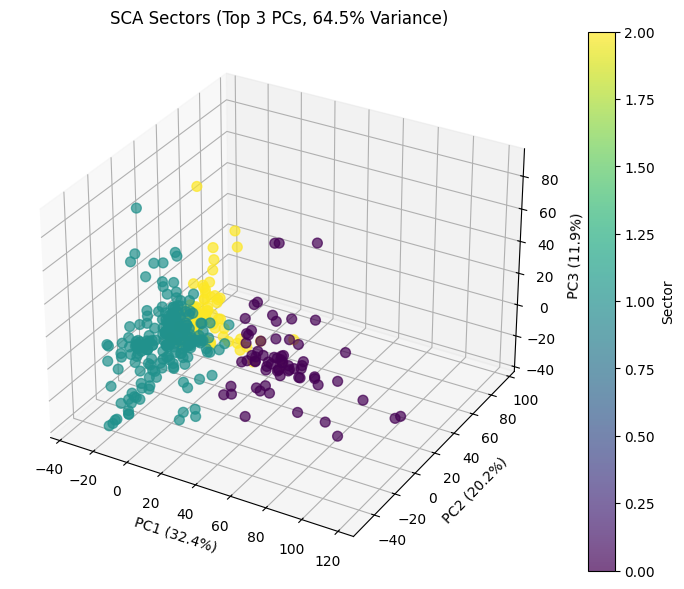

In [86]:
import pandas as pd
df = pd.DataFrame(pcs, columns=['PC1', 'PC2', 'PC3'])
df['Sector'] = clusters

explained_variance = pca.explained_variance_ratio_

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot (color by sector)
scatter = ax.scatter(
    df['PC1'], df['PC2'], df['PC3'],
    c=df['Sector'], cmap='viridis', s=50, alpha=0.7
)

# Label axes with variance explained
ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.1f}%)')
plt.title(f"SCA Sectors (Top 3 PCs, {sum(explained_variance)*100:.1f}% Variance)")
plt.colorbar(scatter, label='Sector')
plt.show()

Now compute entropies, joint entropies

Entropy shape: (1211,) (one value per position)


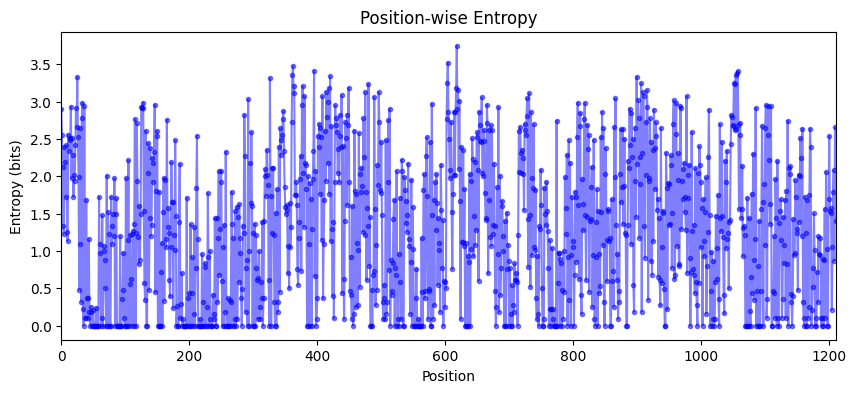

In [30]:
def calculate_entropy(msa_matrix, num_aas=20):  
    n_positions = msa_matrix.shape[1]
    entropy = np.zeros(n_positions)
    
    for pos in range(n_positions):
        column = msa_matrix[:, pos]
        mask = (column != 20)  # Ignore gaps (assuming 20 = gap)
        counts = np.bincount(column[mask], minlength=num_aas)  # Only count AAs 0-19
        frequencies = counts / counts.sum()
        entropy[pos] = -np.sum(frequencies * np.log2(frequencies, where=(frequencies > 0)))
    
    return entropy


num_seqs, num_positions = msa_matrix.shape

entropy = calculate_entropy(msa_matrix)
print(f"Entropy shape: {entropy.shape} (one value per position)")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(entropy, '-o', markersize=3, color = 'Blue', alpha = 0.5)
plt.xlabel("Position")
plt.ylabel("Entropy (bits)")
plt.title("Position-wise Entropy")
plt.xlim(0, num_positions)
plt.show()

corrected covariance calculation

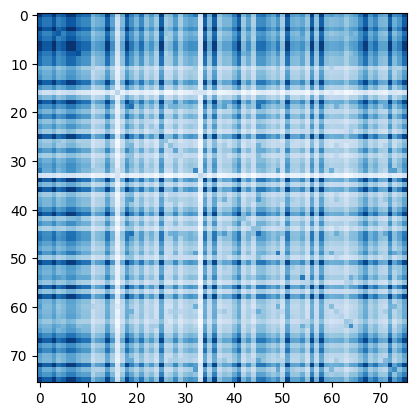

In [128]:
plt.imshow(cov_filt, cmap = 'Blues')

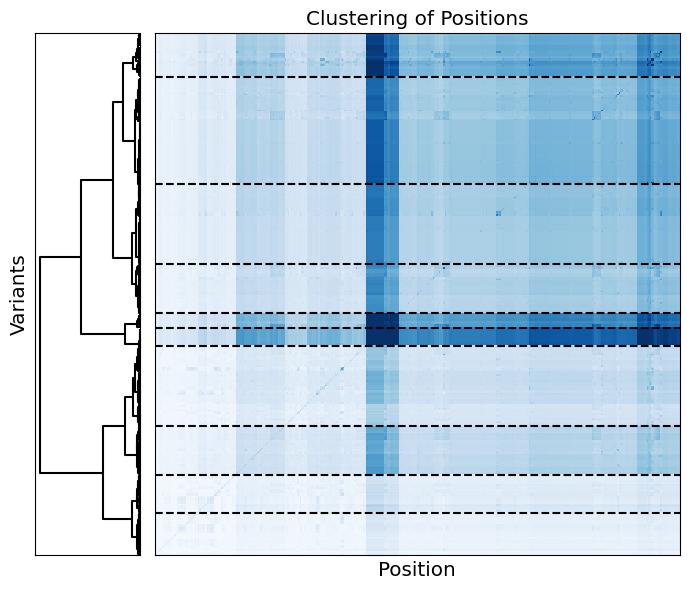

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from matplotlib.colors import to_hex
import numpy as np
import matplotlib.pyplot as plt


Z = linkage(pdist(cov_filt, metric='euclidean'), method='ward')


n_clusters = 10
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')


dendro = dendrogram(Z, no_plot=True)
leaf_indices = dendro['leaves']


cmap = plt.cm.turbo
cluster_colors = [to_hex(cmap(i)) for i in np.linspace(0, 1, n_clusters)]

def color_func(link_idx):
    if link_idx < len(clusters):  # Only color leaf nodes
        return cluster_colors[clusters[link_idx] - 1]
    return "#000000"


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': [0.2, 1]})


dendrogram(Z,
           orientation='left',
           ax=ax1,
           color_threshold=max(Z[-n_clusters+1, 2], 0.1),
           link_color_func=color_func,
           above_threshold_color='k')

ax1.set_ylabel('Variants', fontsize='x-large')
ax1.set_xticks([])
ax1.set_yticks([])


rearranged_data = cov_filt[leaf_indices][:, leaf_indices]
im = ax2.imshow(rearranged_data, aspect='auto', cmap='Blues',
                interpolation='nearest', origin='lower', vmin=0, vmax=100)


boundaries = np.where(np.diff(clusters[leaf_indices]))[0]
for b in boundaries:
    ax2.axhline(b + 0.5, color='black', linestyle='--')

ax2.set_title('Clustering of Positions', fontsize='x-large')
ax2.set_xlabel('Position', fontsize='x-large')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

In [113]:
print(cov.shape)

(1211, 1211)
